In [1]:
!pip install laspy
!pip install open3d
!python3 -m pip install "laspy[lazrs,laszip]"
!pip install cloth-simulation-filter

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: /usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: /usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near

In [2]:
# Imports

import laspy 
import open3d as o3d
import numpy as np
import os
import matplotlib.pyplot as plt
import CSF
from sklearn.metrics import mean_squared_error

In [3]:
# Read the data
las_path = "data.las"
las_data = laspy.read(las_path)

# Extract the points
points = np.vstack((las_data.x, las_data.y, las_data.z)).transpose()

# Create an empty Open3D point cloud object
orig_point_cloud = o3d.geometry.PointCloud()

# Insert the filtered points into the point cloud object
orig_point_cloud.points = o3d.utility.Vector3dVector(points)

#o3d.visualization.draw_geometries([orig_point_cloud])

# Get the number of points in the original point cloud
num_org = len(orig_point_cloud.points)

In [4]:
# Remove ground points with Cloth Simulation Filter algorithm
csf = CSF.CSF()

# prameter settings
csf.params.bSloopSmooth = False
csf.params.cloth_resolution = 0.5
# more details about parameter: http://ramm.bnu.edu.cn/projects/CSF/download/

csf.setPointCloud(points)
ground = CSF.VecInt()  # a list to indicate the index of ground points after calculation
non_ground = CSF.VecInt() # a list to indicate the index of non-ground points after calculation
csf.do_filtering(ground, non_ground) # do actual filtering.

[0] Configuring terrain...
[0] Configuring cloth...
[0]  - width: 272 height: 362
[0] Rasterizing...
[0] Simulating...


In [5]:
# Create a point cloud object without ground points
ground_removed = points[np.array(non_ground)]

# Create an empty Open3D point cloud object
point_cloud_trees = o3d.geometry.PointCloud()

# Insert the filtered points into the point cloud object
point_cloud_trees.points = o3d.utility.Vector3dVector(ground_removed)

#o3d.visualization.draw_geometries([point_cloud_trees])
# Check the reducion of points removing ground points
num_trees = len(point_cloud_trees.points)
reduction = 100-(num_trees/num_org * 100)
print(f'From {num_org} to {num_trees} points. Equals a {round(reduction,2)} % reduction')

From 22176864 to 18879782 points. Equals a 14.87 % reduction


In [6]:
# Downsampling
point_cloud_ds = point_cloud_trees.voxel_down_sample(voxel_size=0.1)
#o3d.visualization.draw_geometries([point_cloud_ds])

# Check the reducion of points after downsampling
num_ds = len(point_cloud_ds.points)
reduction = 100-(num_ds/num_trees * 100)
print(f'From {num_trees} to {num_ds} points. Equals a {round(reduction,2)} % reduction')

From 18879782 to 3291574 points. Equals a 82.57 % reduction


In [7]:
# Terrain filtering using statistical outlier removal (SOR)
point_cloud_so, ind = point_cloud_ds.remove_statistical_outlier(nb_neighbors=20, std_ratio=0.2)
#o3d.visualization.draw_geometries([point_cloud_so])

# Check the reducion of points after downsampling
num_so = len(point_cloud_so.points)
reduction = 100-(num_so/num_ds * 100)
print(f'From {num_ds} to {num_so} points. Equals a {round(reduction,2)} % reduction')

From 3291574 to 2576905 points. Equals a 21.71 % reduction


In [8]:
#Slice the points cloud into 3 different levels
processed_points = np.asarray(point_cloud_so.points)

# define slice levels
slice_levels = [0.2, 0.6, 1.0] # z-values 

# Create a point cloud for the slices
point_cloud_slices = o3d.geometry.PointCloud()

for z_value in slice_levels:
    # Threshold for the thickness of the slice
    z_threshold = 0.05
    # Extract points within the threshold interval
    points_within = (processed_points[:, 2] > (z_value - z_threshold)) & (processed_points[:, 2] < (z_value + z_threshold))
    sliced_points = processed_points[points_within, :3]
    
    # Append slice points to the point cloud slices
    if len(sliced_points) > 0:
        sliced_point_cloud = o3d.geometry.PointCloud()
        sliced_point_cloud.points = o3d.utility.Vector3dVector(sliced_points)
        point_cloud_slices += sliced_point_cloud  

# Visualize all slices together
#o3d.visualization.draw_geometries([point_cloud_slices])

In [9]:
# Find clusters
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        point_cloud_slices.cluster_dbscan(eps=0.5, min_points=5, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
point_cloud_slices.colors = o3d.utility.Vector3dVector(colors[:, :3])
#o3d.visualization.draw_geometries([point_cloud_slices])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
Precompute neighbors.[================>           [Open3D DEBUG] Done Compute Clusters: 393
Precompute neighbors.[========================================] 100%
point cloud has 393 clusters


In [10]:
# Extract individual point clouds to remove unwanted clusters

ind_point_clouds = []
for cluster_label in range(max_label + 1):
    
    cluster_indices = np.where(labels == cluster_label)[0]
    
    cluster_points = point_cloud_slices.select_by_index(cluster_indices)

    # Remove clusters under a certain size
    cluster_size = len(cluster_points.points)
    if(15 < cluster_size < 100):
        ind_point_clouds.append(cluster_points)
        
print(len(ind_point_clouds))

196


In [11]:
# Merge the individual point clouds

# Create an empty point cloud for the complete point cloud
complete_point_cloud = o3d.geometry.PointCloud()

# Iterate over each individual point cloud and add it to the complete point cloud
for point_cloud in ind_point_clouds:
    complete_point_cloud += point_cloud

# Visualize the complete point cloud
#o3d.visualization.draw_geometries([complete_point_cloud])

# Return the number of points in the complete point cloud
len(np.asarray(complete_point_cloud.points))

8081

In [12]:
# Accumulate into 2D plane

# Create an empty list for 2D points
cluster_2d = []

for point_cloud in ind_point_clouds:
    # Convert to numpy array
    points = np.asarray(point_cloud.points)
    # Flatten the Z-coordinate
    points_flatten_z = points[:, :2]
    cluster_2d.append(points_flatten_z)

len(cluster_2d)

196

In [13]:
# Fit circles with RANSAC

def fit_circle_ransac(points, iterations=1000, inlier_thresh=0.03, min_inliers=20, min_inlier_percentage=0.7):
    best_circle = None
    best_inlier_count = 0
    best_inliers = None
    best_inlier_mse = float('inf')
    num_points = len(points)
    
    # Helper function to calculate the distance from points to the circle
    def point_to_circle_dist(points, circle):
        center_x, center_y, radius = circle
        return np.abs(np.sqrt((points[:, 0] - center_x)**2 + (points[:, 1] - center_y)**2) - radius)

    for _ in range(iterations):
        # Randomly select 3 points to define a circle
        sample_points = points[np.random.choice(points.shape[0], 3, replace=False), :]
        circle = fit_circle_least_squares(sample_points)
        
        # Calculate distances from all points to the circle
        distances = point_to_circle_dist(points, circle)
        
        # Determine inliers based on the distance threshold
        inliers_within = distances < inlier_thresh
        inlier_count = np.sum(inliers_within)
        
        if inlier_count > 0:
            # Calculate mean squared error for inliers
            inlier_mse = mean_squared_error(np.zeros(np.sum(inliers_within)), distances[inliers_within])

            inlier_percentage = inlier_count / num_points
            
            # Update best circle if this one has more inliers and a lower MSE
            if inlier_count > best_inlier_count and inlier_count >= min_inliers and inlier_mse < best_inlier_mse and inlier_percentage > min_inlier_percentage:
                best_circle = circle
                best_inlier_count = inlier_count
                best_inliers = inliers_within
                best_inlier_mse = inlier_mse
            
    return best_circle, best_inliers

# Helper function for least squares circle fit
def fit_circle_least_squares(points):
    # Your least squares circle fitting logic
    # For now, let's just use the mean of the points as the center and the average distance to the center as the radius
    center_x = np.mean(points[:, 0])
    center_y = np.mean(points[:, 1])
    radius = np.mean(np.sqrt((points[:, 0] - center_x)**2 + (points[:, 1] - center_y)**2))
    return (center_x, center_y, radius)

def plot_result(points_2d, inliers, circle_parameters):
    print("Best fit circle center: ({}, {}) with radius {}".format(*circle_parameters))
    # Begin plotting
    fig, ax = plt.subplots()
    ax.scatter(points_2d[:, 0], points_2d[:, 1], color='blue', label='Outliers')
    ax.scatter(points_2d[inliers, 0], points_2d[inliers, 1], color='red', label='inliers')

    [center_x, center_y, radius] = circle_parameters
    circle_plot = plt.Circle((center_x, center_y), radius, color='red', fill=False, linewidth=2)
    ax.add_artist(circle_plot)


Best fit circle center: (-10.946839766081872, -24.08547821637427) with radius 0.1962458982251737
Best fit circle center: (23.413074603174607, 11.463437301587305) with radius 0.2501455784449773
Best fit circle center: (14.149040298842829, -6.579909986705611) with radius 0.23752264708483392
Best fit circle center: (11.03216390674524, -5.5920141394357366) with radius 0.2568313738511302
Best fit circle center: (8.100271021234773, -11.294782722388867) with radius 0.197779646217195
Best fit circle center: (4.944985700757576, -17.49974154040404) with radius 0.1712828866872194
Best fit circle center: (-20.1652125, -21.543895833333334) with radius 0.14447533305332103
Best fit circle center: (-14.31495925925926, -18.12931333333333) with radius 0.24685937421006154


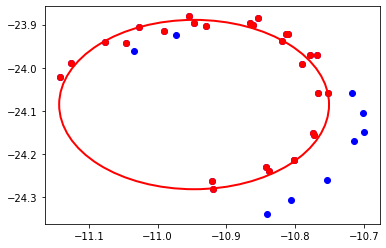

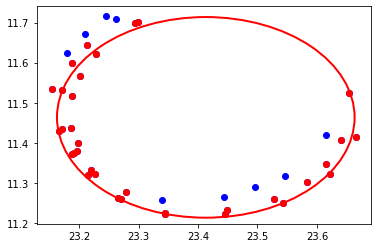

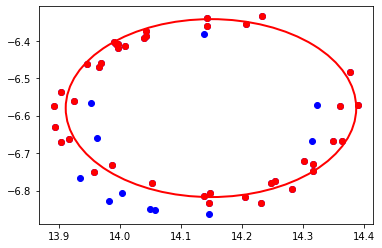

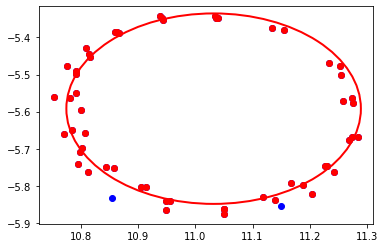

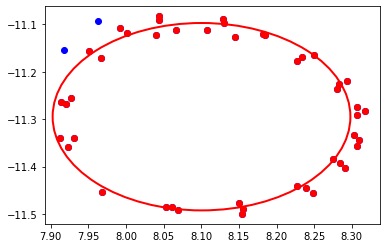

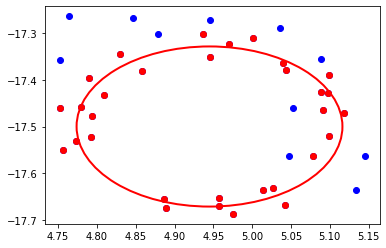

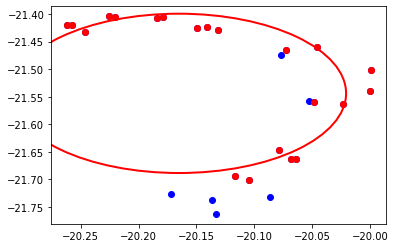

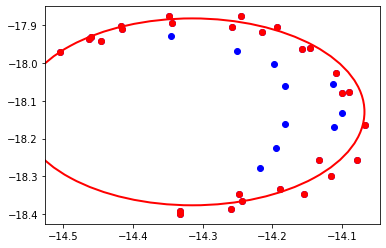

In [14]:
# Plot the best fitted circles

circles = []
for cluster in cluster_2d:
    best_fitted_circle, inliers = fit_circle_ransac(cluster)
    if(best_fitted_circle):
        plot_result(cluster, inliers, best_fitted_circle)
        circles.append(best_fitted_circle)

In [15]:
# Display the detected trees

def create_bounding_box(center, extent):
    obb = o3d.geometry.OrientedBoundingBox()
    obb.center = center
    obb.extent = extent
    return obb

# Define the extent of the bounding box
extent = (5, 5, 40)

# Create an empty list to store the bounding boxes of each circle
bounding_boxes = []
for circle in circles:
    # Create a bounding box for each circle
    BB = create_bounding_box((circle[0], circle[1], 0.0), extent)
    bounding_boxes.append(BB)

# Create an empty point cloud to store the cropped tree points
cropped_tree_point_cloud = o3d.geometry.PointCloud()

# Iterate over the bounding boxes and crop the original point cloud
for bounding_box in bounding_boxes:
    cropped_tree_point_cloud += orig_point_cloud.crop(bounding_box)

# Visualize the cropped tree point cloud
o3d.visualization.draw_geometries([cropped_tree_point_cloud])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


2023-11-14 10:35:50.307 Python[5893:102033] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
